# Dataset preprocessing

The data is initialy explored to understand its contents by displaying its first five rows, dataframe including data types and non null counts, summary statistics for numerical columns, and amount of missing values per column.

In [ ]:
print("\n--- Initial Data Exploration ---")
print("First 5 rows:\n", df.head())
print("\nDataframe info:\n", df.info())
print("\nSummary statistics:\n", df.describe())
print("\nNumber of missing values per column:\n", df.isnull().sum())
print("\nUnique values in categorical columns:\n")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()} unique values")


--- Initial Data Exploration ---
First 5 rows:
    3  Wall St. Bears Claw Back Into the Black (Reuters)  \
0  3  Carlyle Looks Toward Commercial Aerospace (Reu...   
1  3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
2  3  Iraq Halts Oil Exports from Main Southern Pipe...   
3  3  Oil prices soar to all-time record, posing new...   
4  3        Stocks End Up, But Near Year Lows (Reuters)   

  Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.  
0  Reuters - Private investment firm Carlyle Grou...                                              
1  Reuters - Soaring crude prices plus worries\ab...                                              
2  Reuters - Authorities have halted oil export\f...                                              
3  AFP - Tearaway world oil prices, toppling reco...                                              
4  Reuters - Stocks ended slightly higher on Frid...                                              
<c

Train and test sets are loaded individually

In [ ]:
# Individual file paths
train_file_path = os.path.join(folder_path, '/content/drive/MyDrive/ag_news_csv/train.csv')
test_file_path = os.path.join(folder_path, '/content/drive/MyDrive/ag_news_csv/test.csv')

# Load sets into a variable and confirm load
train_df = pd.read_csv(train_file_path, names=['category', 'title', 'details'])
test_df = pd.read_csv(test_file_path, names=['category', 'title', 'details'])

print("Successfully loaded train.csv and test.csv from AG News CSV folder.")

Successfully loaded train.csv and test.csv from AG News CSV folder.


**Words frequency analysis using Wordcloud**

The word cloud below highlights the most frequent words in the reviews, such as New York, quot, AP, new, Monday, Tuesday, Wednesday, one, Reuters, etc.

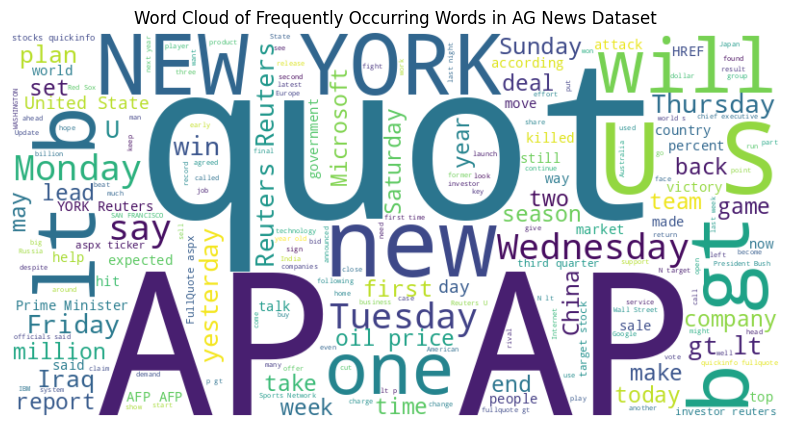

In [ ]:
text_corpus = ' '.join(train_df['title'] + ' ' + train_df['details']) + ' ' + ' '.join(test_df['title'] + ' ' + test_df['details'])

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white').generate(text_corpus)

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off") # to not display axis
plt.title('Word Cloud of Frequently Occurring Words in AG News Dataset')
plt.show()

**Data transformation**: each row was named, the first to third columns are named "category", "title", and "details". The category column previously had values of 1, 2, 3, and 4, where 1 represented "World" news, 2 for "Sports" news, 3 for "Business" news, and 4 for "Sci/Tech" news. These numbers were replaced with the texts to categorise them textually instead of numerically as it provide more clarity if the dataset is looked at.

In [ ]:
# Source the data and use header since the columns have no names
df = pd.read_csv(train_file_path, header=None, names=['category', 'title', 'details'])

# Name each of the three columns
df = df.rename(columns={0: 'category', 1: 'title', 2: 'details'})

# Remap the values in the 'category' column
category_mapping = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tech"
}

df['category'] = df['category'].replace(category_mapping)

# Display the modified DataFrame
print(df.head())
print(df.info())

   category                                              title  \
0  Business  Wall St. Bears Claw Back Into the Black (Reuters)   
1  Business  Carlyle Looks Toward Commercial Aerospace (Reu...   
2  Business    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3  Business  Iraq Halts Oil Exports from Main Southern Pipe...   
4  Business  Oil prices soar to all-time record, posing new...   

                                             details  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   category  120000 non-null  object
 1   title     120000 non-null  object
 2   de

**Data splitting**: the train data is split to train and validation sets, validation is given 20% and the train set is 80%. The test set is only loaded and left untouched as it already exists.

In [ ]:
if 'category' in df.columns:
    X_train_original = df[['title', 'details']]
    y_train_original = df['category']

    train_data, val_data, train_labels, val_labels = train_test_split(
        X_train_original, y_train_original, test_size=0.2, random_state=42, stratify=y_train_original
    )
    print("\nSplitting with stratification based on 'category'")
else:
    print("\n'category' not found in train.csv. Splitting without stratification.")
    train_data, val_data = train_test_split(
        train_df[['title', 'details']], train_df['category'], test_size=0.2, random_state=42, stratify=train_df['category']
    )


# Print the shapes of the resulting datasets
print("\n--- Shapes of the split datasets ---")
print("Training set (from original train.csv):", train_data.shape)
print("Validation set (from original train.csv):", val_data.shape)
print("Test set (from test.csv):", test_df.shape)

# Print label shapes if stratified splitting was performed
if 'category' in df.columns:
    print("Training labels:", train_labels.shape)
    print("Validation labels:", val_labels.shape)


Splitting with stratification based on 'category'

--- Shapes of the split datasets ---
Training set (from original train.csv): (96000, 2)
Validation set (from original train.csv): (24000, 2)
Test set (from test.csv): (7600, 3)
Training labels: (96000,)
Validation labels: (24000,)


**Data cleaning** using Normalisation (removing special characters and normalising spaces), tokenisations (handling common contractions and punctuations marks), case insensitivity (converting to lowersace to treat the same word with different capitilisations as the same), and regular expression (for pattern matching and replacement).

In [ ]:
def clean_str(string):
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`$]", " ", string)
    string = re.sub(r"'s", " 's", string)
    string = re.sub(r"'ve", " 've", string)
    string = re.sub(r"n't", " n't", string)
    string = re.sub(r"'re", " 're", string)
    string = re.sub(r"'d", " 'd", string)
    string = re.sub(r"'ll", " 'll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

Here, I take the text data (titles and details of news articles) and category labels and transform them into a numerical format that can be used to train the models for text classification. In this section,cleaning, tokenization, sequence conversion, padding, and label encoding, which are standard preprocessing steps in NLP tasks are performed.

The output are the variables X_train_padded, X_val_padded, X_test_padded (padded numerical sequences representing the text data) and y_train_one_hot, y_val_one_hot, y_test_one_hot (one-hot encoded labels), which are ready to be used as input for training, validating, and testing the text classification models.

In [ ]:
# Apply cleaning to title and details
train_data['title'] = train_data['title'].apply(clean_str)
train_data['details'] = train_data['details'].apply(clean_str)
val_data['title'] = val_data['title'].apply(clean_str)
val_data['details'] = val_data['details'].apply(clean_str)
test_df['title'] = test_df['title'].apply(clean_str)
test_df['details'] = test_df['details'].apply(clean_str)

# Combine title and details for text input
train_data['text'] = train_data['title'] + ' ' + train_data['details']
val_data['text'] = val_data['title'] + ' ' + val_data['details']
test_df['text'] = test_df['title'] + ' ' + test_df['details']

# Prepare labels
test_df['category'] = test_df['category'].replace(category_mapping)

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_df['category'])

# Vocabulary building
all_texts = pd.concat([train_data['text'], val_data['text'], test_df['text']], axis=0)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000)
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index

# Convert text to sequences
max_length = 200 # You can adjust max_length
X_train_seq = tokenizer.texts_to_sequences(train_data['text'])
X_val_seq = tokenizer.texts_to_sequences(val_data['text'])
X_test_seq = tokenizer.texts_to_sequences(test_df['text'])

# Pad sequences
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_padded = tf.keras.preprocessing.sequence.pad_sequences(X_val_seq, maxlen=max_length, padding='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
y_val_one_hot = tf.keras.utils.to_categorical(val_labels_encoded, num_classes=num_classes)
y_test_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

To reduce compute time and significantly optimise the model performance, I used mixed precision policy. It is embedded in certain parts of the code to enable them run faster.

In [ ]:
# Enable mixed precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32
